In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.0.0'

    Custom Layers by extending tf.keras.layers.Layer

    If you want to create a custom layer without any weights, the simplest
    option is to write a function and wrap it in a keras.layers.Lambda layer. For example,
    the following layer will apply the exponential function to its inputs:
    exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [3]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        '''
        The constructor takes all the hyperparameters as arguments (in this example just
        units and activation), and importantly it also takes a **kwargs argument. It
        calls the parent constructor, passing it the kwargs: this takes care of standard
        arguments such as input_shape, trainable, name, and so on. Then it saves the
        hyperparameters as attributes, converting the activation argument to the
        appropriate activation function using the keras.activations.get() function (it
        accepts functions, standard strings like "relu" or "selu", or simply None)8.
        '''
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        '''
        The build() method’s role is to create the layer’s variables, by calling the
        add_weight() method for each weight. The build() method is called the first
        time the layer is used. At that point, Keras will know the shape of this layer’s
        inputs, and it will pass it to the build() method9, which is often necessary to create
        some of the weights. For example, we need to know the number of neurons in
        the previous layer in order to create the connection weights matrix (i.e., the "ker
        nel"): this corresponds to the size of the last dimension of the inputs. At the end
        of the build() method (and only at the end), you must call the parent’s build()
        method: this tells Keras that the layer is built (it just sets self.built = True).
        '''
        #Creates the variables of the layer (optional, for subclass implementers).
        self.kernel = self.add_weight(name='kernel', shape=[batch_input_shape[-1], self.units], initializer="glorot_normal")
        #add_weight() : Adds a new variable to the layer, or gets an existing one; returns it.
        self.bias = self.add_weight(name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape)
        
    def call(self, X):
        '''
        The call() method actually performs the desired operations. In this case, we
        compute the matrix multiplication of the inputs X and the layer’s kernel, we add
        the bias vector, we apply the activation function to the result, and this gives us the
        output of the layer.
        '''
        return self.activation(X @ self.kernel + self.bias)
    
    def compute_output_shape(self, batch_input_shape):
        '''
        The compute_output_shape() method simply returns the shape of this layer’s
        outputs. In this case, it is the same shape as the inputs, except the last dimension
        is replaced with the number of neurons in the layer. Note that in tf.keras, shapes
        are instances of the tf.TensorShape class, which you can convert to Python lists
        using as_list().
        '''
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config = super().get_config()
        #tf.keras.activations.serialize(self.activation) will return the string equivalent of the activation function.
        return {**base_config, "units":self.units, "activation":tf.keras.activations.serialize(self.activation)}
    
    
        

    You can now use a MyDense layer just like any other layer!

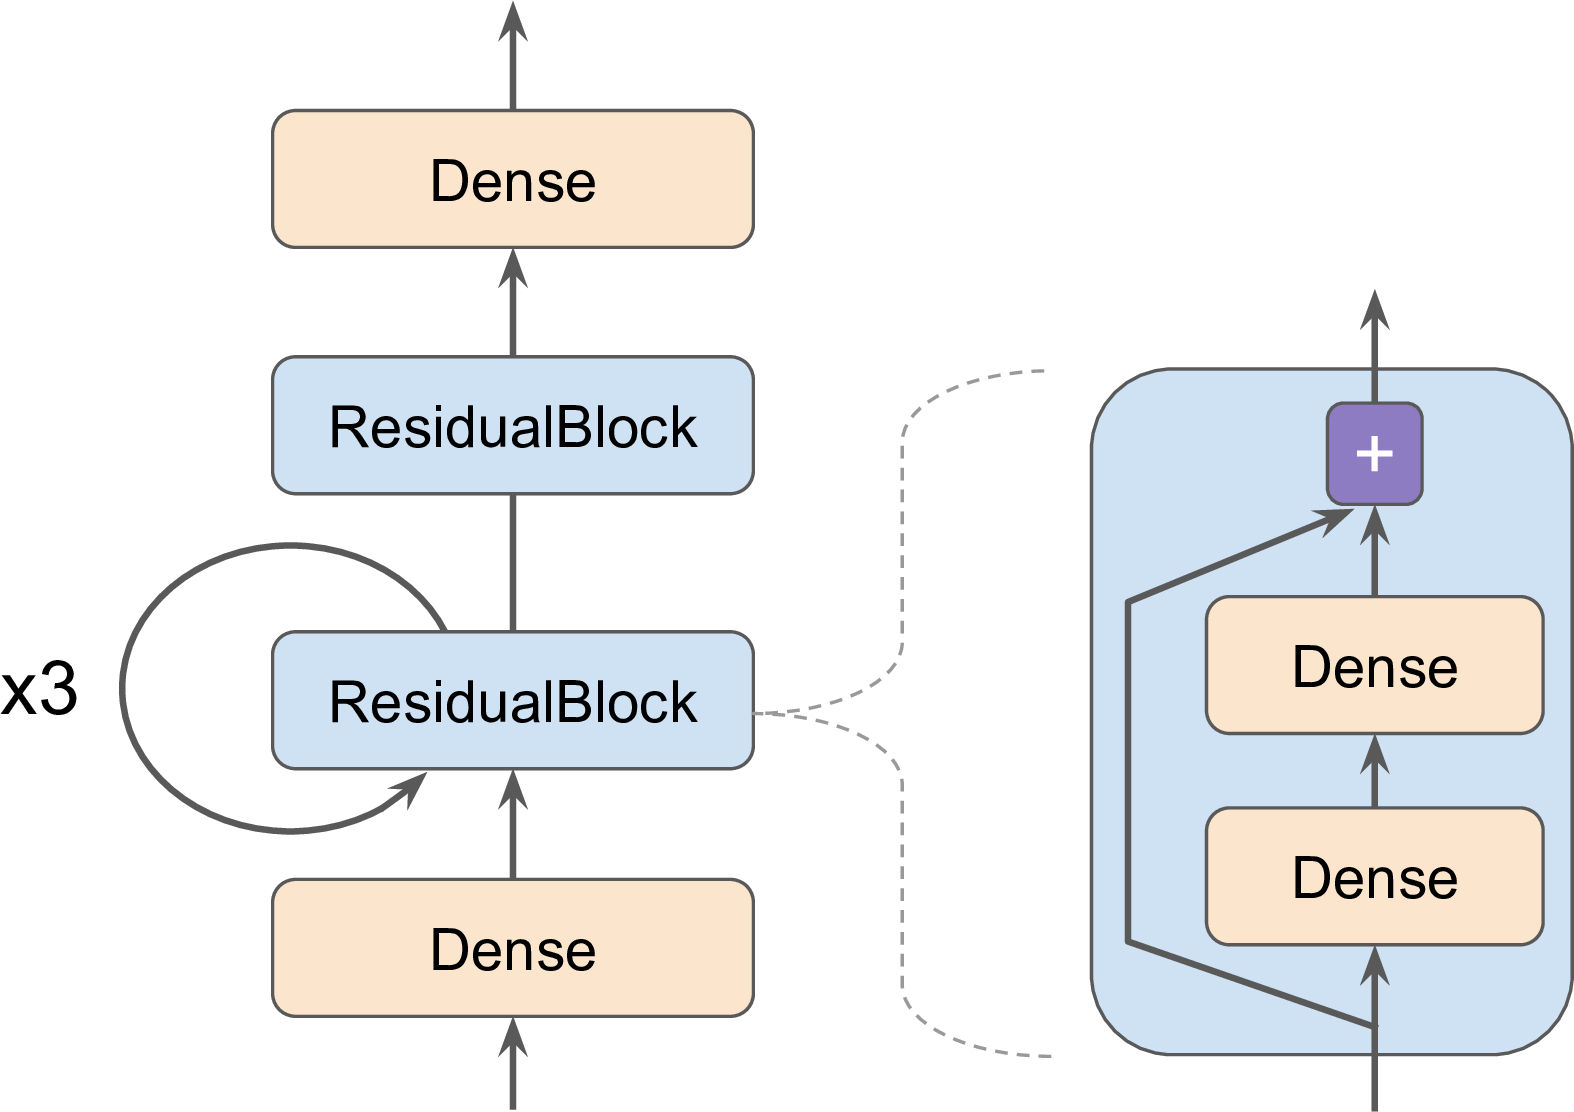

Let's build this custom model

    To implement this model, it is best to first create a
    ResidualBlock layer, since we are going to create a couple identical blocks (and we might want to reuse it in another model):

In [4]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation='elu', kernel_initializer="he_normal") for _ in range(n_layers)]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = self.layer(Z)
        return inputs + Z
        

    Next, let’s use the subclassing API to define the model itself:

In [5]:
class ResidualRegressor(tf.keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(30, activation='elu', kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)
    
    def call(self, inputs):
        z = self.hidden1(inputs)
        for _ in range(3):
            self.block1(z)
        z = self.block2(z)
        return self.out(z)

    there are still a couple things that we need to look at: first, how to define losses or metrics based on model internals, and second how to build a custom training loop.